## Learning Agency Lab - Automated Essay Scoring 

Automatic essay scoring systems are important tools used to evaluate the quality of written texts. This study aims to develop a model for automatic evaluation of student writings. The aim is to create a system that measures the quality of written assignments by analyzing text content. Various natural language processing (NLP) techniques and machine learning methods were used in this process.

Essay writing is an important method to evaluate student learning and performance. It is also time-consuming for educators to grade by hand. Automated Writing Evaluation (AWE) systems can score essays to supplement an educator’s other efforts. AWEs also allow students to receive regular and timely feedback on their writing. However, due to their costs, many advancements in the field are not widely available to students and educators. Open-source solutions to assess student writing are needed to reach every community with these important educational tools.

Competition host Vanderbilt University is a private research university in Nashville, Tennessee. 


<a href='https://www.kaggle.com/competitions/learning-agency-lab-automated-essay-scoring-2/' target=_blank>You can find the competition here</a>

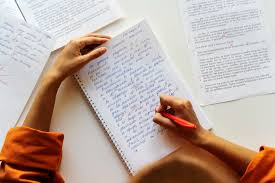

In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/cloudd/cloud.png
/kaggle/input/learning-agency-lab-automated-essay-scoring-2/sample_submission.csv
/kaggle/input/learning-agency-lab-automated-essay-scoring-2/train.csv
/kaggle/input/learning-agency-lab-automated-essay-scoring-2/test.csv


## Import Libraries

In [2]:
import nltk
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [3]:
train=pd.read_csv('/kaggle/input/learning-agency-lab-automated-essay-scoring-2/train.csv')
test=pd.read_csv('/kaggle/input/learning-agency-lab-automated-essay-scoring-2/test.csv')
#Reading the files

## EDA

In [4]:
train.head()

,essay_id,full_text,score
0,000d118,Many people have car where they live. The thin...,3
1,000fe60,I am a scientist at NASA that is discussing th...,3
2,001ab80,People always wish they had the same technolog...,4
3,001bdc0,"We all heard about Venus, the planet without a...",4
4,002ba53,"Dear, State Senator\n\nThis is a letter to arg...",3


In [5]:
test.head()

,essay_id,full_text
0,000d118,Many people have car where they live. The thin...
1,000fe60,I am a scientist at NASA that is discussing th...
2,001ab80,People always wish they had the same technolog...


In [6]:
train.shape, test.shape

((17307, 3), (3, 2))

In [7]:
train.isnull().sum()

essay_id     0
full_text    0
score        0
dtype: int64

In [8]:
test.isnull().sum()

essay_id     0
full_text    0
dtype: int64

In [9]:
df=pd.concat([train,test])
#Merging the files.

In [10]:
df.head()

,essay_id,full_text,score
0,000d118,Many people have car where they live. The thin...,3.0
1,000fe60,I am a scientist at NASA that is discussing th...,3.0
2,001ab80,People always wish they had the same technolog...,4.0
3,001bdc0,"We all heard about Venus, the planet without a...",4.0
4,002ba53,"Dear, State Senator\n\nThis is a letter to arg...",3.0


In [11]:
df['full_text']=df['full_text'].str.lower()
df['full_text']=df['full_text'].str.replace('[^\w\s]','',regex=True)
df['full_text']=df['full_text'].str.replace('\d+','',regex=True)
df['full_text']=df['full_text'].str.replace('\n','',regex=True)
df['full_text']=df['full_text'].str.replace('\r','',regex=True)

In [12]:
df['full_text'][2]

2    people always wish they had the same technolog...
2    people always wish they had the same technolog...
Name: full_text, dtype: object

In [13]:
from unicodedata import normalize
remove_accent = lambda text: normalize("NFKD", text).encode("ascii", "ignore").decode("utf-8", "ignore")

df["full_text"] = df["full_text"].apply(remove_accent)

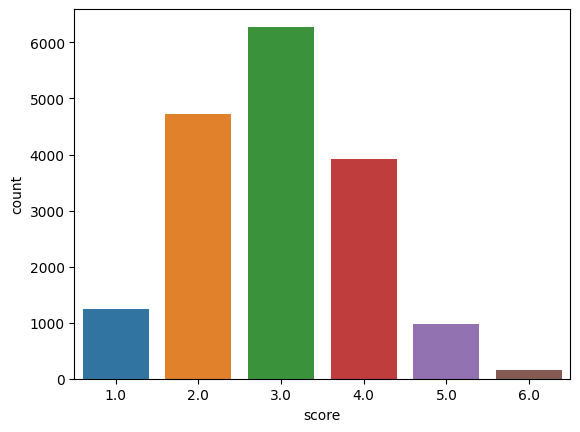

In [14]:
sns.countplot(x=df['score']);

## WordCloud

In [15]:
from wordcloud import WordCloud
from wordcloud import STOPWORDS
from PIL import Image
import numpy as np

In [16]:
def wc(data,bgcolor):
    plt.figure(figsize=(6,6))
    mask=np.array(Image.open('/kaggle/input/cloudd/cloud.png'))
    wc=WordCloud(background_color=bgcolor,stopwords='STOPWORDS',mask=mask)
    wc.generate(' '.join(data))
    plt.imshow(wc)
    plt.axis('off')

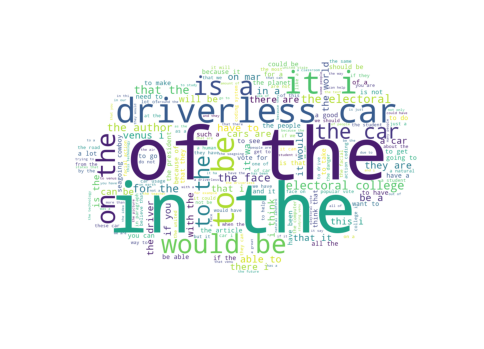

In [17]:
wc(df['full_text'],'white')

## Polarity-Subjectivity

In [18]:
from textblob import TextBlob

In [19]:
df['polarity'] = df['full_text'].apply(lambda x: TextBlob(x).sentiment.polarity)
df['subjectivity']= df['full_text'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

## Vectorization and Lemma-Stemma

In [20]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

In [21]:
from nltk.stem import PorterStemmer
pr=PorterStemmer()

In [22]:
def lemmafn(text):
    words=TextBlob(text).words
    return [pr.stem(word) for word in words]

In [23]:
vect=CountVectorizer(stop_words='english',ngram_range=(1,2),max_features=10000,analyzer=lemmafn)

In [25]:
train.shape

(17307, 3)

In [26]:
train.drop('essay_id', axis=1, inplace=True)

In [27]:
train.head()

,full_text,score
0,Many people have car where they live. The thin...,3
1,I am a scientist at NASA that is discussing th...,3
2,People always wish they had the same technolog...,4
3,"We all heard about Venus, the planet without a...",4
4,"Dear, State Senator\n\nThis is a letter to arg...",3


## Modelling

In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import KFold, cross_val_score
from sklearn.datasets import make_classification

In [28]:
train=df[:17307]
test=df[17307:]

In [29]:
x=train['full_text']
y=train['score']

In [30]:
x=vect.fit_transform(x)

In [31]:
x_train,x_test,y_train,y_test= train_test_split(x,y, random_state=42,test_size=.20)

In [32]:
r=RandomForestClassifier()
model=r.fit(x_train,y_train)
rpred=r.predict(x_test)
accuracy_score(rpred,y_test)

0.549104563835933

In [33]:
print(classification_report(rpred, y_test))

              precision    recall  f1-score   support

         1.0       0.04      0.91      0.07        11
         2.0       0.61      0.61      0.61       968
         3.0       0.76      0.53      0.62      1818
         4.0       0.45      0.52      0.48       656
         5.0       0.02      0.33      0.03         9
         6.0       0.00      0.00      0.00         0

    accuracy                           0.55      3462
   macro avg       0.31      0.48      0.30      3462
weighted avg       0.66      0.55      0.59      3462



In [34]:
confusion_matrix(rpred, y_test)

array([[ 10,   1,   0,   0,   0,   0],
       [180, 586, 196,   6,   0,   0],
       [ 67, 364, 963, 404,  20,   0],
       [  3,  14, 106, 339, 160,  34],
       [  0,   0,   0,   1,   3,   5],
       [  0,   0,   0,   0,   0,   0]])

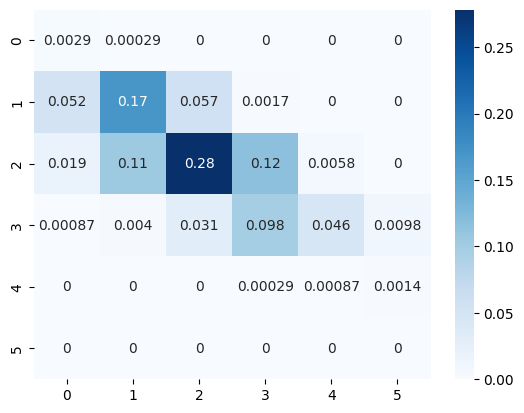

In [35]:
cm = confusion_matrix(rpred, y_test)
normalized_cm = cm / cm.sum()
sns.heatmap(normalized_cm, annot=True, cmap='Blues');

In [36]:
#K-Fold Cross Validation
x=train['full_text']
y=train['score']
x=vect.fit_transform(x)

model=RandomForestClassifier()

#K-fold cross validation (K=5)
kf=KFold(n_splits=5, shuffle=True, random_state=42)

#Calculating cross validation results
scores = cross_val_score(model, x, y, cv=kf, scoring='accuracy')

#Average of results
print(f"Accuracy Scores: {scores}")
print(f"Mean Accuracy: {scores.mean()}")

Accuracy Scores: [0.5407279  0.54794916 0.5550419  0.55215256 0.54348454]
Mean Accuracy: 0.5478712119580884


In [37]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import  BernoulliNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def algo_test(x, y):
    
    lr = LogisticRegression(max_iter=1000)
    b = BernoulliNB()
    nb = MultinomialNB()
    knn = KNeighborsClassifier()
    dt = DecisionTreeClassifier()
    rf = RandomForestClassifier()
    abc = AdaBoostClassifier()
    gbc = GradientBoostingClassifier()
    svc = SVC()
    mlp = MLPClassifier(max_iter=1000)

    algos = [lr, b, nb, knn, dt, rf, abc, gbc, svc, mlp]
    algo_names = ['Logistic Regression', 'BernoulliNB', 'MultinomialNB', 'K-Nearest Neighbors',
                  'Decision Tree', 'Random Forest', 'AdaBoost', 'Gradient Boosting', 'SVM', 'MLP Classifier']

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

    accuracy = []
    precision = []
    recall = []
    f1 = []

    
    result = pd.DataFrame(columns=['Accuracy', 'Precision', 'Recall', 'F1-score'], index=algo_names)
    
    for algo in algos:
        algo.fit(x_train, y_train)
        y_pred = algo.predict(x_test)
        accuracy.append(accuracy_score(y_test, y_pred))
        precision.append(precision_score(y_test, y_pred, average='weighted'))
        recall.append(recall_score(y_test, y_pred, average='weighted'))
        f1.append(f1_score(y_test, y_pred, average='weighted'))
        
    result['Accuracy'] = accuracy
    result['Precision'] = precision
    result['Recall'] = recall
    result['F1-score'] = f1
    
    
    rtable = result.sort_values('Accuracy', ascending=False)
    return rtable


In [46]:
algo_test(x,y)

,Accuracy,Precision,Recall,F1-score
SVM,0.605719,0.612354,0.605719,0.583657
Gradient Boosting,0.558059,0.561241,0.558059,0.546780
Random Forest,0.542172,0.562369,0.542172,0.501217
Logistic Regression,0.524552,0.521721,0.524552,0.522864
K-Nearest Neighbors,0.475448,0.489578,0.475448,0.460551
MLP Classifier,0.464183,0.459092,0.464183,0.458797
BernoulliNB,0.458983,0.481700,0.458983,0.457849
AdaBoost,0.454073,0.448178,0.454073,0.430796
Decision Tree,0.432120,0.428644,0.432120,0.430187
MultinomialNB,0.297805,0.363428,0.297805,0.297156


## Test Data Prediction

In [38]:
test1=test.drop('score',axis=1)

In [39]:
test1=vect.transform(test['full_text'])

In [40]:
svc = SVC()
svc.fit(x,y)
pred=svc.predict(test1)

In [41]:
pred1=pd.DataFrame()
pred1['essay_id']=test['essay_id']
pred1['score']=pred

In [42]:
pred1

,essay_id,score
0,000d118,3.0
1,000fe60,3.0
2,001ab80,4.0


In [43]:
pred1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3 entries, 0 to 2
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   essay_id  3 non-null      object 
 1   score     3 non-null      float64
dtypes: float64(1), object(1)
memory usage: 72.0+ bytes


In [44]:
pred1.to_csv('submission_lal.csv', index=False)

## Summary

The training and test data sets were combined to allow all data to be analyzed as a single set. Unnecessary characters such as punctuation marks and numbers were removed. The texts were simplified by removing accents (e.g. special characters). A word cloud was created from the given text column and the most frequently used words were visualized. This was useful for determining key themes in the text. The emotional state (polarity) and subjectivity analyses of the texts were performed. These analyses were used to understand the general attitude of the texts. Lemmatization and stemming processes were applied to reduce the words to their roots. This step was important for better understanding the subtleties of the language. The text data was converted to numerical data. This process is necessary for machine learning algorithms to process the texts. The data was divided into training (x, y) and test sets. This was prepared to be used in the training and evaluation stages of the model. The model was trained with the selected machine learning algorithm. In this step, the learning process of the model began. Various metrics were used to evaluate the performance of the model: Confusion Matrix: It was used to visualize the prediction performance of the model.

Classification Report: Metrics such as accuracy, recall and F1 score were calculated. K-Fold Cross Validation: It was implemented to evaluate the overall performance of the model more reliably. The trained model made predictions on the test dataset and the results were obtained. The prediction results were saved in a CSV file format. This file was prepared so that the results could be analyzed or shared later.

This study covers a process where a series of natural language processing and machine learning techniques were used to develop automatic essay scoring systems. The analyses and model evaluations provided important information for the automatic evaluation of written texts. Such systems can play a critical role in education to evaluate student performance and provide feedback.